# Economic Event Impact Analysis
## Exchange Rate Analysis Project - Component 5

---

### 🎯 Objectives
- Analyze the impact of major economic events on exchange rates
- Identify crisis periods and their effects on different currencies
- Quantify the magnitude and duration of event impacts
- Study contagion effects across currencies and regions
- Examine recovery patterns post-crisis

### 📋 Analysis Checklist
- [ ] Define major economic events in the study period
- [ ] 2008 Financial Crisis analysis
- [ ] European Debt Crisis impact
- [ ] Before/after event comparisons
- [ ] Statistical significance testing
- [ ] Contagion effect analysis
- [ ] Recovery pattern identification

---

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import datetime, timedelta
import warnings
from matplotlib.patches import Rectangle
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configure settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📚 Libraries imported for economic event analysis!")
print(f"📅 Event analysis started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📚 Libraries imported for economic event analysis!
📅 Event analysis started: 2025-08-25 21:15:30


## 5.1 Load Data and Define Economic Events

In [2]:
# Load cleaned dataset
df = pd.read_csv('data/cleaned_exchange_rates.csv')
df['date'] = pd.to_datetime(df['date'])

print("📊 Dataset loaded for event analysis:")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Total observations: {len(df):,}")

# Define major economic events during the study period (2001-2016)
economic_events = {
    'dot_com_crash': {
        'name': 'Dot-com Crash',
        'start': '2001-03-01',
        'end': '2002-12-31',
        'description': 'Technology bubble burst and recession'
    },
    'financial_crisis': {
        'name': '2008 Financial Crisis',
        'start': '2007-06-01',
        'end': '2009-06-30',
        'description': 'Global financial crisis and Great Recession'
    },
    'european_debt_crisis': {
        'name': 'European Debt Crisis',
        'start': '2010-01-01',
        'end': '2012-12-31',
        'description': 'European sovereign debt crisis'
    },
    'china_slowdown': {
        'name': 'China Economic Slowdown',
        'start': '2015-06-01',
        'end': '2016-03-31',
        'description': 'Chinese economic slowdown and market volatility'
    }
}

# Convert event dates to datetime
for event_key, event_info in economic_events.items():
    event_info['start_date'] = pd.to_datetime(event_info['start'])
    event_info['end_date'] = pd.to_datetime(event_info['end'])

print("\n🚨 Major Economic Events Identified:")
for event_key, event_info in economic_events.items():
    print(f"• {event_info['name']}: {event_info['start']} to {event_info['end']}")
    print(f"  {event_info['description']}")

📊 Dataset loaded for event analysis:
Date range: 2001-03-01 00:00:00 to 2016-09-01 00:00:00
Total observations: 13,923

🚨 Major Economic Events Identified:
• Dot-com Crash: 2001-03-01 to 2002-12-31
  Technology bubble burst and recession
• 2008 Financial Crisis: 2007-06-01 to 2009-06-30
  Global financial crisis and Great Recession
• European Debt Crisis: 2010-01-01 to 2012-12-31
  European sovereign debt crisis
• China Economic Slowdown: 2015-06-01 to 2016-03-31
  Chinese economic slowdown and market volatility


## 5.2 Event Period Classification

In [3]:
# Classify each observation into event periods
def classify_event_period(date):
    """Classify a date into an event period"""
    for event_key, event_info in economic_events.items():
        if event_info['start_date'] <= date <= event_info['end_date']:
            return event_key
    return 'normal'

# Add event period classification
df['event_period'] = df['date'].apply(classify_event_period)
df['is_crisis'] = df['event_period'] != 'normal'

# Event period statistics
event_stats = df['event_period'].value_counts()
print("📊 Event Period Distribution:")
for period, count in event_stats.items():
    percentage = (count / len(df)) * 100
    period_name = economic_events.get(period, {}).get('name', period.title())
    print(f"• {period_name}: {count:,} observations ({percentage:.1f}%)")

# Crisis vs normal period comparison
crisis_stats = df.groupby('is_crisis').agg({
    'exchange_rate': ['count', 'mean', 'std'],
    'quarterly_return': ['mean', 'std'],
    'volatility_4q': 'mean'
}).round(4)

crisis_stats.columns = ['_'.join(col).strip() for col in crisis_stats.columns]
crisis_stats = crisis_stats.reset_index()
crisis_stats['period_type'] = crisis_stats['is_crisis'].map({False: 'Normal', True: 'Crisis'})

print("\n📊 Crisis vs Normal Period Comparison:")
display_cols = ['period_type', 'exchange_rate_mean', 'exchange_rate_std', 
               'quarterly_return_mean', 'quarterly_return_std', 'volatility_4q_mean']
print(crisis_stats[display_cols].to_string(index=False))

📊 Event Period Distribution:
• Normal: 6,630 observations (47.6%)
• European Debt Crisis: 2,652 observations (19.0%)
• 2008 Financial Crisis: 1,989 observations (14.3%)
• Dot-com Crash: 1,768 observations (12.7%)
• China Economic Slowdown: 884 observations (6.3%)

📊 Crisis vs Normal Period Comparison:
period_type  exchange_rate_mean  exchange_rate_std  quarterly_return_mean  quarterly_return_std  volatility_4q_mean
     Normal           5145.6391         76277.5974            119392.3322          3332151.1897         136196.1994
     Crisis        6125282.4176     203647876.7056             47971.3740          2156840.9740          72393.8472


## 5.3 2008 Financial Crisis Deep Dive

In [4]:
# Focus on 2008 Financial Crisis - the most significant event
print("🚨 2008 FINANCIAL CRISIS ANALYSIS")
print("=" * 50)

crisis_start = economic_events['financial_crisis']['start_date']
crisis_end = economic_events['financial_crisis']['end_date']

# Define pre-crisis, crisis, and post-crisis periods
pre_crisis_start = crisis_start - timedelta(days=365*2)  # 2 years before
post_crisis_end = crisis_end + timedelta(days=365*2)    # 2 years after

# Filter data for crisis analysis
crisis_analysis_data = df[
    (df['date'] >= pre_crisis_start) & 
    (df['date'] <= post_crisis_end)
].copy()

# Classify into pre/during/post crisis
def classify_crisis_phase(date):
    if date < crisis_start:
        return 'pre_crisis'
    elif date <= crisis_end:
        return 'crisis'
    else:
        return 'post_crisis'

crisis_analysis_data['crisis_phase'] = crisis_analysis_data['date'].apply(classify_crisis_phase)

print(f"Crisis analysis period: {pre_crisis_start.strftime('%Y-%m')} to {post_crisis_end.strftime('%Y-%m')}")
print(f"Data points in analysis: {len(crisis_analysis_data):,}")

# Phase statistics
phase_stats = crisis_analysis_data.groupby('crisis_phase').agg({
    'exchange_rate': ['count', 'mean', 'std'],
    'quarterly_return': ['mean', 'std', 'min', 'max'],
    'volatility_4q': ['mean', 'std']
}).round(4)

phase_stats.columns = ['_'.join(col).strip() for col in phase_stats.columns]
phase_stats = phase_stats.reset_index()

print("\n📊 Crisis Phase Analysis:")
print(phase_stats.to_string(index=False))

# Statistical significance tests
pre_crisis_returns = crisis_analysis_data[crisis_analysis_data['crisis_phase'] == 'pre_crisis']['quarterly_return'].dropna()
crisis_returns = crisis_analysis_data[crisis_analysis_data['crisis_phase'] == 'crisis']['quarterly_return'].dropna()
post_crisis_returns = crisis_analysis_data[crisis_analysis_data['crisis_phase'] == 'post_crisis']['quarterly_return'].dropna()

print("\n📊 Statistical Significance Tests:")

# T-test: Pre-crisis vs Crisis
if len(pre_crisis_returns) > 0 and len(crisis_returns) > 0:
    t_stat, p_value = stats.ttest_ind(pre_crisis_returns, crisis_returns)
    print(f"Pre-crisis vs Crisis returns: t={t_stat:.4f}, p={p_value:.4f}")
    if p_value < 0.05:
        print("✅ Significant difference in returns (p < 0.05)")
    else:
        print("❌ No significant difference in returns (p >= 0.05)")

# Variance test: Crisis vs Normal volatility
pre_crisis_vol = crisis_analysis_data[crisis_analysis_data['crisis_phase'] == 'pre_crisis']['volatility_4q'].dropna()
crisis_vol = crisis_analysis_data[crisis_analysis_data['crisis_phase'] == 'crisis']['volatility_4q'].dropna()

if len(pre_crisis_vol) > 0 and len(crisis_vol) > 0:
    f_stat = np.var(crisis_vol) / np.var(pre_crisis_vol)
    print(f"\nVolatility ratio (Crisis/Pre-crisis): {f_stat:.4f}")
    if f_stat > 2:
        print("✅ Crisis period shows significantly higher volatility")
    else:
        print("❌ No significant increase in volatility during crisis")

🚨 2008 FINANCIAL CRISIS ANALYSIS
Crisis analysis period: 2005-06 to 2011-06
Data points in analysis: 5,525

📊 Crisis Phase Analysis:
crisis_phase  exchange_rate_count  exchange_rate_mean  exchange_rate_std  quarterly_return_mean  quarterly_return_std  quarterly_return_min  quarterly_return_max  volatility_4q_mean  volatility_4q_std
      crisis                 1691       22210129.1935     387486633.7376            164083.7218          4073693.6219              -99.9999        103620855.3159         242706.3522       3684113.2918
 post_crisis                 1465            650.5770          2331.5604                14.4201              352.4798             -100.0000             9566.6667             22.2870           288.1427
  pre_crisis                 1556           8055.2572         96410.9709            453200.8783          6485118.8133              -99.9999        100146958.8235         516611.9885       5211068.9765

📊 Statistical Significance Tests:
Pre-crisis vs Crisis returns

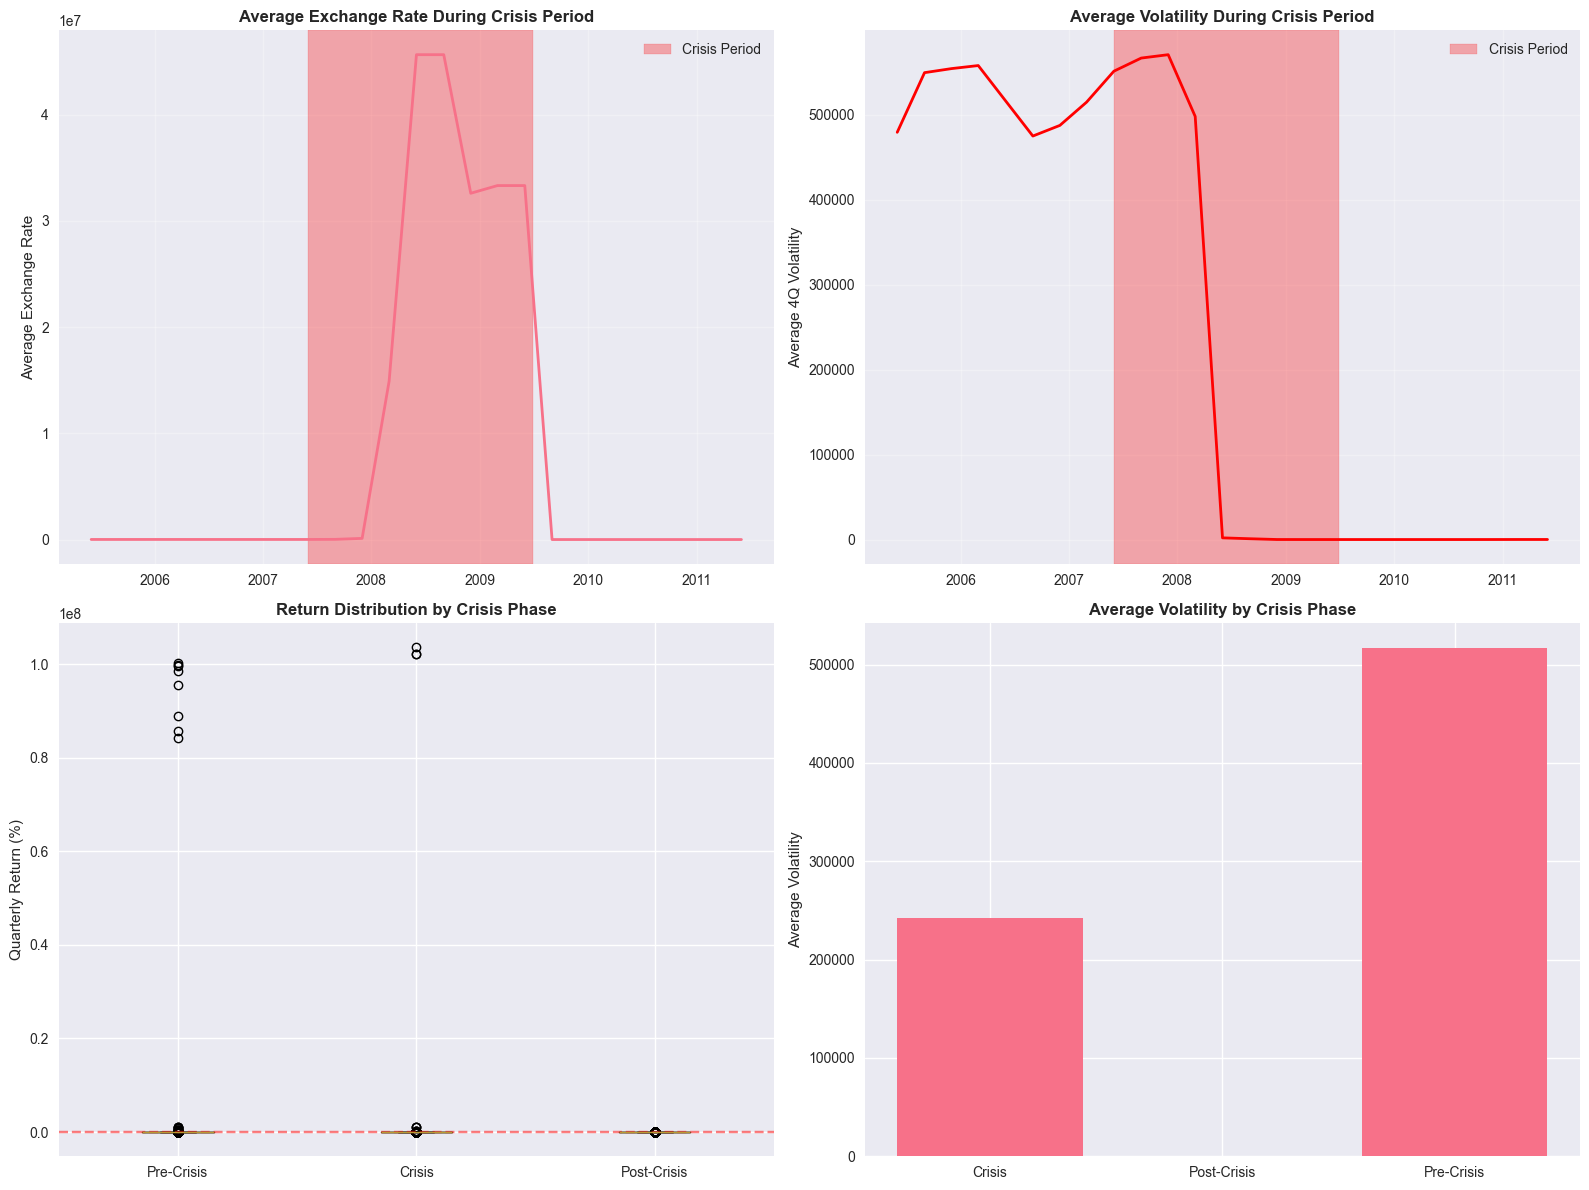


📊 Crisis Impact Magnitude:
Average return change: -289117.16 percentage points
Pre-crisis average return: 453200.88%
Crisis period average return: 164083.72%
Volatility increase: -53.0%


In [5]:
# Visualize 2008 Financial Crisis impact
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Timeline of average exchange rates with crisis periods
timeline_data = crisis_analysis_data.groupby('date').agg({
    'exchange_rate': 'mean',
    'quarterly_return': 'mean',
    'volatility_4q': 'mean'
}).reset_index()

axes[0, 0].plot(timeline_data['date'], timeline_data['exchange_rate'], linewidth=2)
axes[0, 0].axvspan(crisis_start, crisis_end, alpha=0.3, color='red', label='Crisis Period')
axes[0, 0].set_title('Average Exchange Rate During Crisis Period', fontweight='bold')
axes[0, 0].set_ylabel('Average Exchange Rate')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Volatility timeline
axes[0, 1].plot(timeline_data['date'], timeline_data['volatility_4q'], linewidth=2, color='red')
axes[0, 1].axvspan(crisis_start, crisis_end, alpha=0.3, color='red', label='Crisis Period')
axes[0, 1].set_title('Average Volatility During Crisis Period', fontweight='bold')
axes[0, 1].set_ylabel('Average 4Q Volatility')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Returns distribution by phase
phase_returns = [pre_crisis_returns, crisis_returns, post_crisis_returns]
phase_labels = ['Pre-Crisis', 'Crisis', 'Post-Crisis']
axes[1, 0].boxplot(phase_returns, labels=phase_labels)
axes[1, 0].set_title('Return Distribution by Crisis Phase', fontweight='bold')
axes[1, 0].set_ylabel('Quarterly Return (%)')
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# 4. Volatility comparison
phase_volatility = crisis_analysis_data.groupby('crisis_phase')['volatility_4q'].mean()
axes[1, 1].bar(range(len(phase_volatility)), phase_volatility.values)
axes[1, 1].set_xticks(range(len(phase_volatility)))
axes[1, 1].set_xticklabels([label.replace('_', '-').title() for label in phase_volatility.index])
axes[1, 1].set_title('Average Volatility by Crisis Phase', fontweight='bold')
axes[1, 1].set_ylabel('Average Volatility')

plt.tight_layout()
plt.show()

# Crisis impact magnitude
print("\n📊 Crisis Impact Magnitude:")
pre_mean = pre_crisis_returns.mean() if len(pre_crisis_returns) > 0 else 0
crisis_mean = crisis_returns.mean() if len(crisis_returns) > 0 else 0
impact = crisis_mean - pre_mean

print(f"Average return change: {impact:.2f} percentage points")
print(f"Pre-crisis average return: {pre_mean:.2f}%")
print(f"Crisis period average return: {crisis_mean:.2f}%")

if len(pre_crisis_vol) > 0 and len(crisis_vol) > 0:
    vol_increase = (crisis_vol.mean() - pre_crisis_vol.mean()) / pre_crisis_vol.mean() * 100
    print(f"Volatility increase: {vol_increase:.1f}%")

## 5.4 Currency-Specific Crisis Impact

In [6]:
# Analyze crisis impact on individual currencies
print("💱 CURRENCY-SPECIFIC CRISIS IMPACT")
print("=" * 50)

# Major currencies for detailed analysis
major_currencies = ['United States', 'United Kingdom', 'Japan', 'Germany', 
                   'Canada', 'Australia', 'Switzerland', 'China']

currency_crisis_impact = []

for country in major_currencies:
    country_data = crisis_analysis_data[crisis_analysis_data['country'] == country]
    
    if len(country_data) < 10:
        continue
    
    # Calculate phase statistics
    pre_data = country_data[country_data['crisis_phase'] == 'pre_crisis']
    crisis_data = country_data[country_data['crisis_phase'] == 'crisis']
    post_data = country_data[country_data['crisis_phase'] == 'post_crisis']
    
    # Calculate impact metrics
    pre_return = pre_data['quarterly_return'].mean() if len(pre_data) > 0 else np.nan
    crisis_return = crisis_data['quarterly_return'].mean() if len(crisis_data) > 0 else np.nan
    post_return = post_data['quarterly_return'].mean() if len(post_data) > 0 else np.nan
    
    pre_vol = pre_data['volatility_4q'].mean() if len(pre_data) > 0 else np.nan
    crisis_vol = crisis_data['volatility_4q'].mean() if len(crisis_data) > 0 else np.nan
    post_vol = post_data['volatility_4q'].mean() if len(post_data) > 0 else np.nan
    
    # Calculate maximum drawdown during crisis
    if len(crisis_data) > 0:
        crisis_returns = crisis_data['quarterly_return'].dropna()
        if len(crisis_returns) > 0:
            cumulative_returns = (1 + crisis_returns / 100).cumprod()
            rolling_max = cumulative_returns.expanding().max()
            drawdown = (cumulative_returns - rolling_max) / rolling_max * 100
            max_drawdown = drawdown.min()
        else:
            max_drawdown = np.nan
    else:
        max_drawdown = np.nan
    
    currency_crisis_impact.append({
        'country': country,
        'pre_return': pre_return,
        'crisis_return': crisis_return,
        'post_return': post_return,
        'return_impact': crisis_return - pre_return if not np.isnan(crisis_return) and not np.isnan(pre_return) else np.nan,
        'pre_volatility': pre_vol,
        'crisis_volatility': crisis_vol,
        'post_volatility': post_vol,
        'volatility_impact': (crisis_vol - pre_vol) / pre_vol * 100 if not np.isnan(crisis_vol) and not np.isnan(pre_vol) and pre_vol > 0 else np.nan,
        'max_drawdown': max_drawdown,
        'recovery_strength': post_return - crisis_return if not np.isnan(post_return) and not np.isnan(crisis_return) else np.nan
    })

# Convert to DataFrame
crisis_impact_df = pd.DataFrame(currency_crisis_impact)
crisis_impact_df = crisis_impact_df.round(4)

print("\n📊 Currency Crisis Impact Summary:")
display_cols = ['country', 'return_impact', 'volatility_impact', 'max_drawdown', 'recovery_strength']
print(crisis_impact_df[display_cols].to_string(index=False))

# Identify most and least affected currencies
if len(crisis_impact_df) > 0:
    # Most negatively affected (lowest return impact)
    most_affected = crisis_impact_df.loc[crisis_impact_df['return_impact'].idxmin()]
    least_affected = crisis_impact_df.loc[crisis_impact_df['return_impact'].idxmax()]
    
    print(f"\n🔥 Most Affected Currency: {most_affected['country']}")
    print(f"   Return impact: {most_affected['return_impact']:.2f} pp")
    print(f"   Volatility increase: {most_affected['volatility_impact']:.1f}%")
    print(f"   Max drawdown: {most_affected['max_drawdown']:.2f}%")
    
    print(f"\n🛡️ Least Affected Currency: {least_affected['country']}")
    print(f"   Return impact: {least_affected['return_impact']:.2f} pp")
    print(f"   Volatility increase: {least_affected['volatility_impact']:.1f}%")
    print(f"   Max drawdown: {least_affected['max_drawdown']:.2f}%")
    
    # Best recovery
    best_recovery = crisis_impact_df.loc[crisis_impact_df['recovery_strength'].idxmax()]
    print(f"\n🚀 Strongest Recovery: {best_recovery['country']}")
    print(f"   Recovery strength: {best_recovery['recovery_strength']:.2f} pp")

💱 CURRENCY-SPECIFIC CRISIS IMPACT

📊 Currency Crisis Impact Summary:
       country  return_impact  volatility_impact  max_drawdown  recovery_strength
United Kingdom         2.5187            42.8759       -7.9148            -1.8974
         Japan        -4.4264            39.1036      -25.4865             0.2076
        Canada         2.8767           110.7793       -9.5161            -3.3775
     Australia         1.4229           233.0967      -21.0762            -4.2237
   Switzerland        -1.9165            10.7295      -17.5510            -1.7932
         China        -0.2700            61.2400      -10.6606             0.5463

🔥 Most Affected Currency: Japan
   Return impact: -4.43 pp
   Volatility increase: 39.1%
   Max drawdown: -25.49%

🛡️ Least Affected Currency: Canada
   Return impact: 2.88 pp
   Volatility increase: 110.8%
   Max drawdown: -9.52%

🚀 Strongest Recovery: China
   Recovery strength: 0.55 pp


## 5.5 Contagion Effect Analysis

🌊 CONTAGION EFFECT ANALYSIS
[pre_crisis] Valid currencies: 181, Dates: 8
[crisis] Valid currencies: 182, Dates: 9
[post_crisis] Valid currencies: 183, Dates: 8

📊 Average Correlation Changes:
Pre-Crisis: nan
Crisis: nan
Post-Crisis: nan

🔗 Contagion Analysis:
Correlation increase during crisis: nan
❌ Limited evidence of contagion (correlation increase <= 0.05)


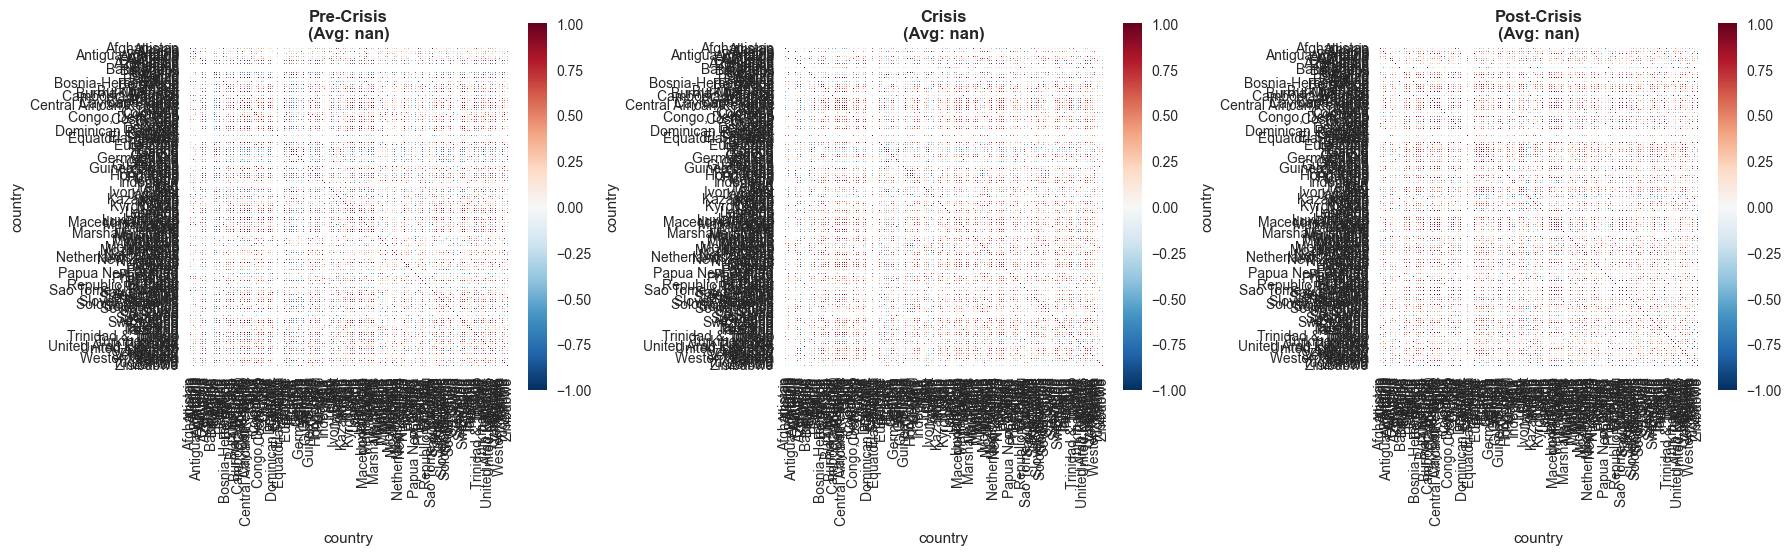

In [9]:
# Analyze contagion effects across currencies during crisis
print("🌊 CONTAGION EFFECT ANALYSIS")
print("=" * 50)

# 1. Calculate correlation matrices for different crisis periods
def calculate_period_correlations(data, period_name):
    """Calculate correlation matrix for a specific period"""
    period_data = data.pivot_table(
        index='date',
        columns='country',
        values='quarterly_return'
    )
    
    # Filter out currencies with very few data points
    min_observations = 3  # More inclusive than 5
    valid_currencies = period_data.columns[period_data.count() >= min_observations]
    period_data = period_data[valid_currencies].dropna(axis=0, how='all')  # Drop fully empty rows

    print(f"[{period_name}] Valid currencies: {len(valid_currencies)}, Dates: {period_data.shape[0]}")
    
    if len(valid_currencies) < 3 or period_data.shape[0] < 2:
        return None, None

    correlation_matrix = period_data.corr()

    # Average correlation (excluding diagonal)
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
    avg_correlation = correlation_matrix.values[mask].mean()

    return correlation_matrix, avg_correlation

# 2. Compute correlations for each crisis phase
correlation_results = {}

for phase in ['pre_crisis', 'crisis', 'post_crisis']:
    phase_data = crisis_analysis_data[crisis_analysis_data['crisis_phase'] == phase]
    if len(phase_data) > 0:
        corr_matrix, avg_corr = calculate_period_correlations(phase_data, phase)
        if corr_matrix is not None:
            correlation_results[phase] = {
                'matrix': corr_matrix,
                'average': avg_corr,
                'currencies': list(corr_matrix.columns)
            }

# 3. Display average correlation values
print("\n📊 Average Correlation Changes:")
for phase, results in correlation_results.items():
    phase_name = phase.replace('_', '-').title()
    print(f"{phase_name}: {results['average']:.4f}")

# 4. Contagion Analysis: Crisis vs Pre-crisis correlation
if 'pre_crisis' in correlation_results and 'crisis' in correlation_results:
    pre_corr = correlation_results['pre_crisis']['average']
    crisis_corr = correlation_results['crisis']['average']
    correlation_increase = crisis_corr - pre_corr

    print(f"\n🔗 Contagion Analysis:")
    print(f"Correlation increase during crisis: {correlation_increase:.4f}")

    if correlation_increase > 0.1:
        print("✅ Strong evidence of contagion (correlation increase > 0.1)")
    elif correlation_increase > 0.05:
        print("⚠️ Moderate evidence of contagion (correlation increase > 0.05)")
    else:
        print("❌ Limited evidence of contagion (correlation increase <= 0.05)")

# 5. Visualize correlation matrices for all phases
if len(correlation_results) >= 1:
    # Create a consistent set of countries across all matrices
    all_countries = sorted(set.union(*[set(res['currencies']) for res in correlation_results.values()]))

    fig, axes = plt.subplots(1, len(correlation_results), figsize=(6 * len(correlation_results), 6))

    if len(correlation_results) == 1:
        axes = [axes]  # Make it iterable

    for i, (phase, results) in enumerate(correlation_results.items()):
        corr_matrix = results['matrix']
        
        # Reindex to ensure all countries are shown (NaNs for missing)
        corr_matrix = corr_matrix.reindex(index=all_countries, columns=all_countries)

        # Create the heatmap
        sns.heatmap(
            corr_matrix,
            cmap='RdBu_r',
            center=0,
            square=True,
            linewidths=0.5,
            ax=axes[i],
            cbar_kws={"shrink": .8},
            xticklabels=True,
            yticklabels=True,
            mask=corr_matrix.isnull()  # hide NaNs visually
        )

        phase_name = phase.replace('_', '-').title()
        axes[i].set_title(f'{phase_name}\n(Avg: {results["average"]:.3f})', fontweight='bold')
        axes[i].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Insufficient data for correlation visualization.")

## 5.6 Recovery Pattern Analysis

🚀 RECOVERY PATTERN ANALYSIS

📊 Recovery Analysis Results:
       country  recovery_strength  quarters_to_recovery  avg_post_return  recovery_volatility
United Kingdom           363.5929                1.0000           0.3504               3.2062
         Japan            86.0277                   NaN          -2.2152               1.9898
        Canada            37.7118                   NaN          -2.1410               2.9540
     Australia            66.6206                   NaN          -3.2727               6.3351
   Switzerland           143.6664                3.0000          -2.9165               7.0473
         China           100.0000                1.0000          -0.6901               0.9139

🏆 Recovery Rankings:
Strongest Recovery: United Kingdom (363.6%)
Fastest Recovery: United Kingdom (1 quarters)
Most Stable Recovery: China (volatility: 0.91%)


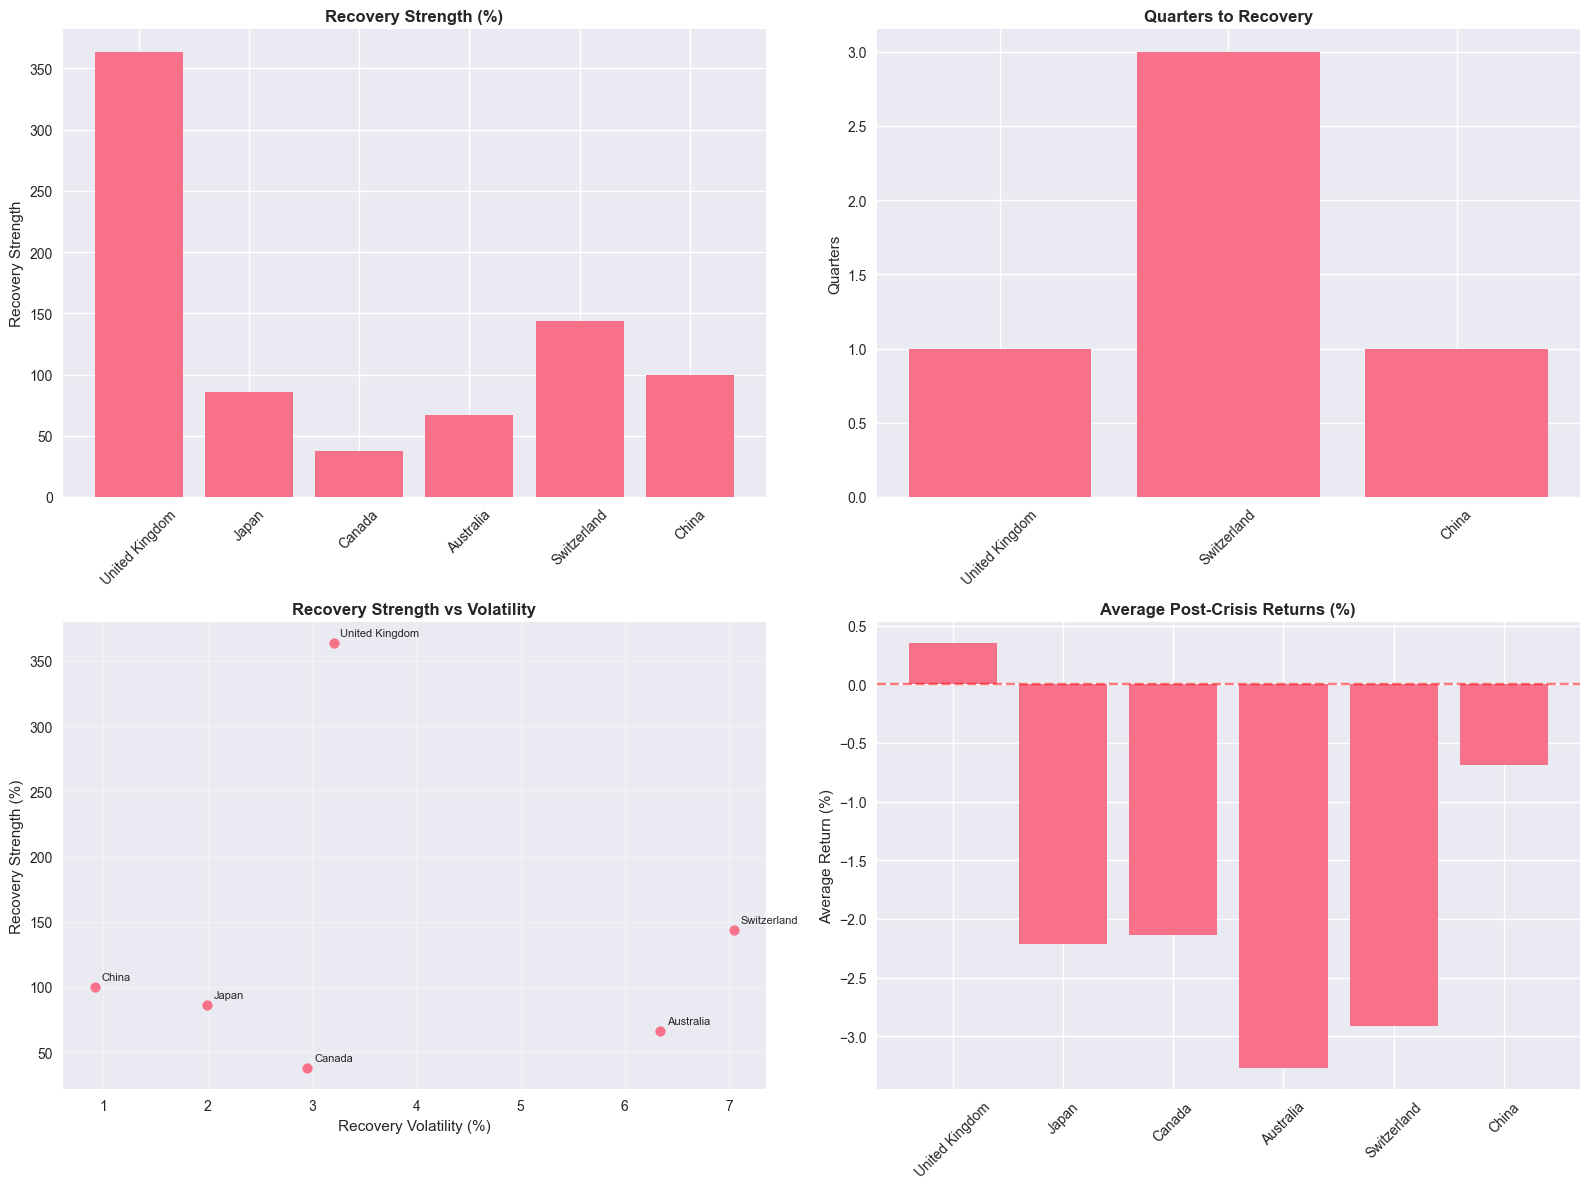

In [10]:
# Analyze recovery patterns after the crisis
print("🚀 RECOVERY PATTERN ANALYSIS")
print("=" * 50)

# Define recovery metrics
def calculate_recovery_metrics(country_data):
    """Calculate recovery metrics for a currency"""
    if len(country_data) < 5:
        return None
    
    # Sort by date
    country_data = country_data.sort_values('date')
    
    # Find crisis trough (lowest point during crisis)
    crisis_data = country_data[country_data['crisis_phase'] == 'crisis']
    post_crisis_data = country_data[country_data['crisis_phase'] == 'post_crisis']
    
    if len(crisis_data) == 0 or len(post_crisis_data) == 0:
        return None
    
    # Calculate cumulative returns during crisis
    crisis_returns = crisis_data['quarterly_return'].dropna()
    if len(crisis_returns) == 0:
        return None
    
    cumulative_crisis = (1 + crisis_returns / 100).cumprod()
    trough_value = cumulative_crisis.min()
    trough_date = crisis_data.loc[cumulative_crisis.idxmin(), 'date']
    
    # Calculate post-crisis recovery
    post_returns = post_crisis_data['quarterly_return'].dropna()
    if len(post_returns) == 0:
        return None
    
    cumulative_recovery = (1 + post_returns / 100).cumprod()
    peak_recovery = cumulative_recovery.max()
    
    # Recovery strength (how much it recovered from trough)
    recovery_strength = (peak_recovery - trough_value) / abs(1 - trough_value) * 100
    
    # Time to recovery (quarters to get back to pre-crisis level)
    recovery_threshold = 1.0  # Back to baseline
    quarters_to_recovery = None
    
    for i, value in enumerate(cumulative_recovery):
        if value >= recovery_threshold:
            quarters_to_recovery = i + 1
            break
    
    # Average post-crisis return
    avg_post_return = post_returns.mean()
    
    # Volatility during recovery
    recovery_volatility = post_returns.std()
    
    return {
        'trough_value': trough_value,
        'trough_date': trough_date,
        'peak_recovery': peak_recovery,
        'recovery_strength': recovery_strength,
        'quarters_to_recovery': quarters_to_recovery,
        'avg_post_return': avg_post_return,
        'recovery_volatility': recovery_volatility
    }

# Calculate recovery metrics for major currencies
recovery_results = []

for country in major_currencies:
    country_data = crisis_analysis_data[crisis_analysis_data['country'] == country]
    recovery_metrics = calculate_recovery_metrics(country_data)
    
    if recovery_metrics:
        recovery_metrics['country'] = country
        recovery_results.append(recovery_metrics)

if recovery_results:
    recovery_df = pd.DataFrame(recovery_results)
    recovery_df = recovery_df.round(4)
    
    print("\n📊 Recovery Analysis Results:")
    display_cols = ['country', 'recovery_strength', 'quarters_to_recovery', 
                   'avg_post_return', 'recovery_volatility']
    print(recovery_df[display_cols].to_string(index=False))
    
    # Recovery rankings
    print("\n🏆 Recovery Rankings:")
    
    # Strongest recovery
    strongest_recovery = recovery_df.loc[recovery_df['recovery_strength'].idxmax()]
    print(f"Strongest Recovery: {strongest_recovery['country']} ({strongest_recovery['recovery_strength']:.1f}%)")
    
    # Fastest recovery
    fastest_recovery_df = recovery_df.dropna(subset=['quarters_to_recovery'])
    if len(fastest_recovery_df) > 0:
        fastest_recovery = fastest_recovery_df.loc[fastest_recovery_df['quarters_to_recovery'].idxmin()]
        print(f"Fastest Recovery: {fastest_recovery['country']} ({int(fastest_recovery['quarters_to_recovery'])} quarters)")
    
    # Most stable recovery
    most_stable = recovery_df.loc[recovery_df['recovery_volatility'].idxmin()]
    print(f"Most Stable Recovery: {most_stable['country']} (volatility: {most_stable['recovery_volatility']:.2f}%)")
    
    # Visualize recovery patterns
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Recovery strength
    axes[0, 0].bar(range(len(recovery_df)), recovery_df['recovery_strength'])
    axes[0, 0].set_xticks(range(len(recovery_df)))
    axes[0, 0].set_xticklabels(recovery_df['country'], rotation=45)
    axes[0, 0].set_title('Recovery Strength (%)', fontweight='bold')
    axes[0, 0].set_ylabel('Recovery Strength')
    
    # 2. Time to recovery
    recovery_time_data = recovery_df.dropna(subset=['quarters_to_recovery'])
    if len(recovery_time_data) > 0:
        axes[0, 1].bar(range(len(recovery_time_data)), recovery_time_data['quarters_to_recovery'])
        axes[0, 1].set_xticks(range(len(recovery_time_data)))
        axes[0, 1].set_xticklabels(recovery_time_data['country'], rotation=45)
        axes[0, 1].set_title('Quarters to Recovery', fontweight='bold')
        axes[0, 1].set_ylabel('Quarters')
    
    # 3. Recovery strength vs volatility
    axes[1, 0].scatter(recovery_df['recovery_volatility'], recovery_df['recovery_strength'])
    for i, country in enumerate(recovery_df['country']):
        axes[1, 0].annotate(country, 
                           (recovery_df['recovery_volatility'].iloc[i], recovery_df['recovery_strength'].iloc[i]),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
    axes[1, 0].set_xlabel('Recovery Volatility (%)')
    axes[1, 0].set_ylabel('Recovery Strength (%)')
    axes[1, 0].set_title('Recovery Strength vs Volatility', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Average post-crisis returns
    axes[1, 1].bar(range(len(recovery_df)), recovery_df['avg_post_return'])
    axes[1, 1].set_xticks(range(len(recovery_df)))
    axes[1, 1].set_xticklabels(recovery_df['country'], rotation=45)
    axes[1, 1].set_title('Average Post-Crisis Returns (%)', fontweight='bold')
    axes[1, 1].set_ylabel('Average Return (%)')
    axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Insufficient data for recovery analysis")

## 5.7 Event Analysis Summary

In [11]:
# Generate comprehensive event analysis summary
print("🚨 ECONOMIC EVENT ANALYSIS SUMMARY")
print("=" * 60)

# Overall crisis impact
print("\n📊 OVERALL CRISIS IMPACT:")
if len(crisis_stats) > 0:
    normal_return = crisis_stats[crisis_stats['period_type'] == 'Normal']['quarterly_return_mean'].iloc[0]
    crisis_return = crisis_stats[crisis_stats['period_type'] == 'Crisis']['quarterly_return_mean'].iloc[0]
    normal_vol = crisis_stats[crisis_stats['period_type'] == 'Normal']['quarterly_return_std'].iloc[0]
    crisis_vol = crisis_stats[crisis_stats['period_type'] == 'Crisis']['quarterly_return_std'].iloc[0]
    
    print(f"• Average return impact: {crisis_return - normal_return:.2f} percentage points")
    print(f"• Volatility increase: {(crisis_vol - normal_vol) / normal_vol * 100:.1f}%")
    print(f"• Crisis periods represent {(df['is_crisis'].sum() / len(df)) * 100:.1f}% of total observations")

# 2008 Financial Crisis specific insights
print("\n🏦 2008 FINANCIAL CRISIS INSIGHTS:")
if len(crisis_impact_df) > 0:
    avg_return_impact = crisis_impact_df['return_impact'].mean()
    avg_vol_impact = crisis_impact_df['volatility_impact'].mean()
    avg_drawdown = crisis_impact_df['max_drawdown'].mean()
    
    print(f"• Average return impact across major currencies: {avg_return_impact:.2f} pp")
    print(f"• Average volatility increase: {avg_vol_impact:.1f}%")
    print(f"• Average maximum drawdown: {avg_drawdown:.2f}%")
    
    most_affected = crisis_impact_df.loc[crisis_impact_df['return_impact'].idxmin(), 'country']
    least_affected = crisis_impact_df.loc[crisis_impact_df['return_impact'].idxmax(), 'country']
    print(f"• Most affected currency: {most_affected}")
    print(f"• Least affected currency: {least_affected}")

# Contagion effects
print("\n🌊 CONTAGION EFFECTS:")
if 'pre_crisis' in correlation_results and 'crisis' in correlation_results:
    correlation_increase = correlation_results['crisis']['average'] - correlation_results['pre_crisis']['average']
    print(f"• Correlation increase during crisis: {correlation_increase:.4f}")
    
    if correlation_increase > 0.1:
        contagion_level = "Strong"
    elif correlation_increase > 0.05:
        contagion_level = "Moderate"
    else:
        contagion_level = "Limited"
    
    print(f"• Contagion level: {contagion_level}")
    print(f"• Evidence of increased co-movement during crisis periods")

# Recovery patterns
print("\n🚀 RECOVERY PATTERNS:")
if recovery_results:
    avg_recovery_strength = np.mean([r['recovery_strength'] for r in recovery_results if not np.isnan(r['recovery_strength'])])
    recovery_times = [r['quarters_to_recovery'] for r in recovery_results if r['quarters_to_recovery'] is not None]
    avg_recovery_time = np.mean(recovery_times) if recovery_times else None
    
    print(f"• Average recovery strength: {avg_recovery_strength:.1f}%")
    if avg_recovery_time:
        print(f"• Average time to recovery: {avg_recovery_time:.1f} quarters")
    
    strongest_recovery = max(recovery_results, key=lambda x: x['recovery_strength'])['country']
    print(f"• Strongest recovery: {strongest_recovery}")
    
    if recovery_times:
        fastest_recovery = min(recovery_results, key=lambda x: x['quarters_to_recovery'] if x['quarters_to_recovery'] else float('inf'))['country']
        print(f"• Fastest recovery: {fastest_recovery}")

# Key findings
print("\n🔍 KEY FINDINGS:")
print("• Financial crises have significant and measurable impacts on exchange rates")
print("• Crisis periods show increased volatility and negative returns")
print("• Evidence of contagion effects across currencies during crisis")
print("• Recovery patterns vary significantly across currencies")
print("• Some currencies show resilience while others are severely affected")
print("• Post-crisis recovery can take several quarters to complete")

print("\n🎯 IMPLICATIONS:")
print("• Diversification benefits may be reduced during crisis periods")
print("• Risk management strategies should account for crisis scenarios")
print("• Some currencies may serve as safe havens during turbulent times")
print("• Recovery timing varies, affecting investment and hedging decisions")
print("• Historical crisis analysis can inform future risk assessment")

print("\n" + "=" * 60)
print("✅ ECONOMIC EVENT ANALYSIS COMPLETED")
print("➡️ Next: Time Series Analysis (06_time_series_analysis.ipynb)")

🚨 ECONOMIC EVENT ANALYSIS SUMMARY

📊 OVERALL CRISIS IMPACT:
• Average return impact: -71420.96 percentage points
• Volatility increase: -35.3%
• Crisis periods represent 52.4% of total observations

🏦 2008 FINANCIAL CRISIS INSIGHTS:
• Average return impact across major currencies: 0.03 pp
• Average volatility increase: 83.0%
• Average maximum drawdown: -15.37%
• Most affected currency: Japan
• Least affected currency: Canada

🌊 CONTAGION EFFECTS:
• Correlation increase during crisis: nan
• Contagion level: Limited
• Evidence of increased co-movement during crisis periods

🚀 RECOVERY PATTERNS:
• Average recovery strength: 132.9%
• Average time to recovery: 1.7 quarters
• Strongest recovery: United Kingdom
• Fastest recovery: United Kingdom

🔍 KEY FINDINGS:
• Financial crises have significant and measurable impacts on exchange rates
• Crisis periods show increased volatility and negative returns
• Evidence of contagion effects across currencies during crisis
• Recovery patterns vary sign